In [1]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from backtest_functions_v2 import *

In [2]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v3.parquet")

In [3]:
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_2h,reddit_total_sentiment_ewm_100h,reddit_average_sentiment_ewm_2h,reddit_average_sentiment_ewm_100h
2021-01-01 06:00:00,2.0,0.850000,0.0,0.0,0.0,0.15,0.0,-0.007795,219.4000,351.4194,...,0,0,0,0,0,0,-0.891000,-0.891000,-0.111375,-0.111375
2021-01-01 07:00:00,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.003292,253.0935,336.2693,...,0,0,0,0,0,0,-0.445500,-0.873356,-0.055688,-0.109170
2021-01-01 08:00:00,2.0,0.400000,0.0,0.0,0.0,0.50,0.0,-0.001883,284.9410,309.6284,...,1,1,1,0,0,0,-0.222750,-0.856062,-0.027844,-0.107008
2021-01-01 09:00:00,2.0,-0.050000,0.0,0.0,0.0,0.40,0.0,-0.001648,326.5890,301.5680,...,1,1,1,0,0,0,-0.111375,-0.839111,-0.013922,-0.104889
2021-01-01 10:00:00,3.0,0.766667,0.0,0.0,0.0,0.30,0.0,0.000118,351.1670,289.6874,...,1,1,1,0,0,0,-0.055688,-0.822494,-0.006961,-0.102812


In [4]:
columns = df.columns.tolist()
for i in range(0, len(columns), 5):
  print(columns[i:i+5])

['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa']
['adoption_absa', 'cybersecurity_absa', 'return_forward', 'sma_5_20_diff', 'sma_20_50_diff']
['sma_50_200_diff', 'ema_5_20_diff', 'ema_20_50_diff', 'ema_50_200_diff', 'sma_5_20_diff_abs_chg']
['sma_5_20_diff_pct_chg', 'sma_20_50_diff_abs_chg', 'sma_20_50_diff_pct_chg', 'sma_50_200_diff_abs_chg', 'sma_50_200_diff_pct_chg']
['ema_5_20_diff_abs_chg', 'ema_5_20_diff_pct_chg', 'ema_20_50_diff_abs_chg', 'ema_20_50_diff_pct_chg', 'ema_50_200_diff_abs_chg']
['ema_50_200_diff_pct_chg', 'macd_12_26', 'signal_line_9', 'macd_histogram', 'macd_position']
['macd_crossover', 'adx', '+di', '-di', 'adx_slope']
['adx_strength', 'di_crossover', 'di_spread', 'adx_di_composite', 'rsi_7']
['rsi_14', 'rsi_7_slope', 'rsi_7_chg', 'rsi_7_acceleration', 'rsi_14_slope']
['rsi_14_chg', 'rsi_14_acceleration', 'rsi_ratio', 'atr_7', 'atr_14']
['atr_7_slope', 'atr_7_chg', 'atr_14_slope', 'atr_14_chg', 'norm_price_change_7']
['norm_p

### Spliting dataset

In [ ]:
all_features = df.columns.drop(['target', 'return_forward'])

In [6]:
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### Logistic regression model - using all features

In [7]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('model', OneVsRestClassifier(LogisticRegression(
    solver='saga',
    max_iter=13000,
    random_state=42,
    class_weight='balanced',
    penalty='l1'
  )))
])

# Parameter grid for GridSearchCV
param_grid = {
  'model__estimator__C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10] # Regularization strength
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(
  estimator=pipeline,
  param_grid=param_grid,
  cv=tscv,
  scoring='roc_auc_ovr',
  n_jobs=-1,
  verbose=1
)

# Fit GridSearchCV on the training data
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"GridSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation ROC AUC score: ", grid_search.best_score_)

# Get the best estimator
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV fitting time: 1324.05 seconds
Best parameters found:  {'model__estimator__C': 0.005}
Best cross-validation ROC AUC score:  0.5879489966412944


Shape of coefficient matrix: (3, 147)

Top 15 most important features for Bearish (0):
                           Feature  Coefficient  Abs_Coefficient
67                        pct_b_10     0.126414         0.126414
48                          atr_14     0.093996         0.093996
70                            year    -0.081668         0.081668
55                       atr_ratio     0.053526         0.053526
72         tanalysis_absa_ewm_100h    -0.041043         0.041043
95           source_Coindesk_last3     0.030072         0.030072
127           NER_blackrock_last24    -0.020066         0.020066
91   source_Bitcoin Magazine_last3     0.019524         0.019524
105           source_NewsBTC_last3     0.015113         0.015113
74           economy_absa_ewm_100h    -0.013892         0.013892
53             norm_price_change_7     0.012310         0.012310
103     source_Cryptopolitan_last3     0.010824         0.010824
132                  NER_fed_last3     0.009492         0.009492
17 

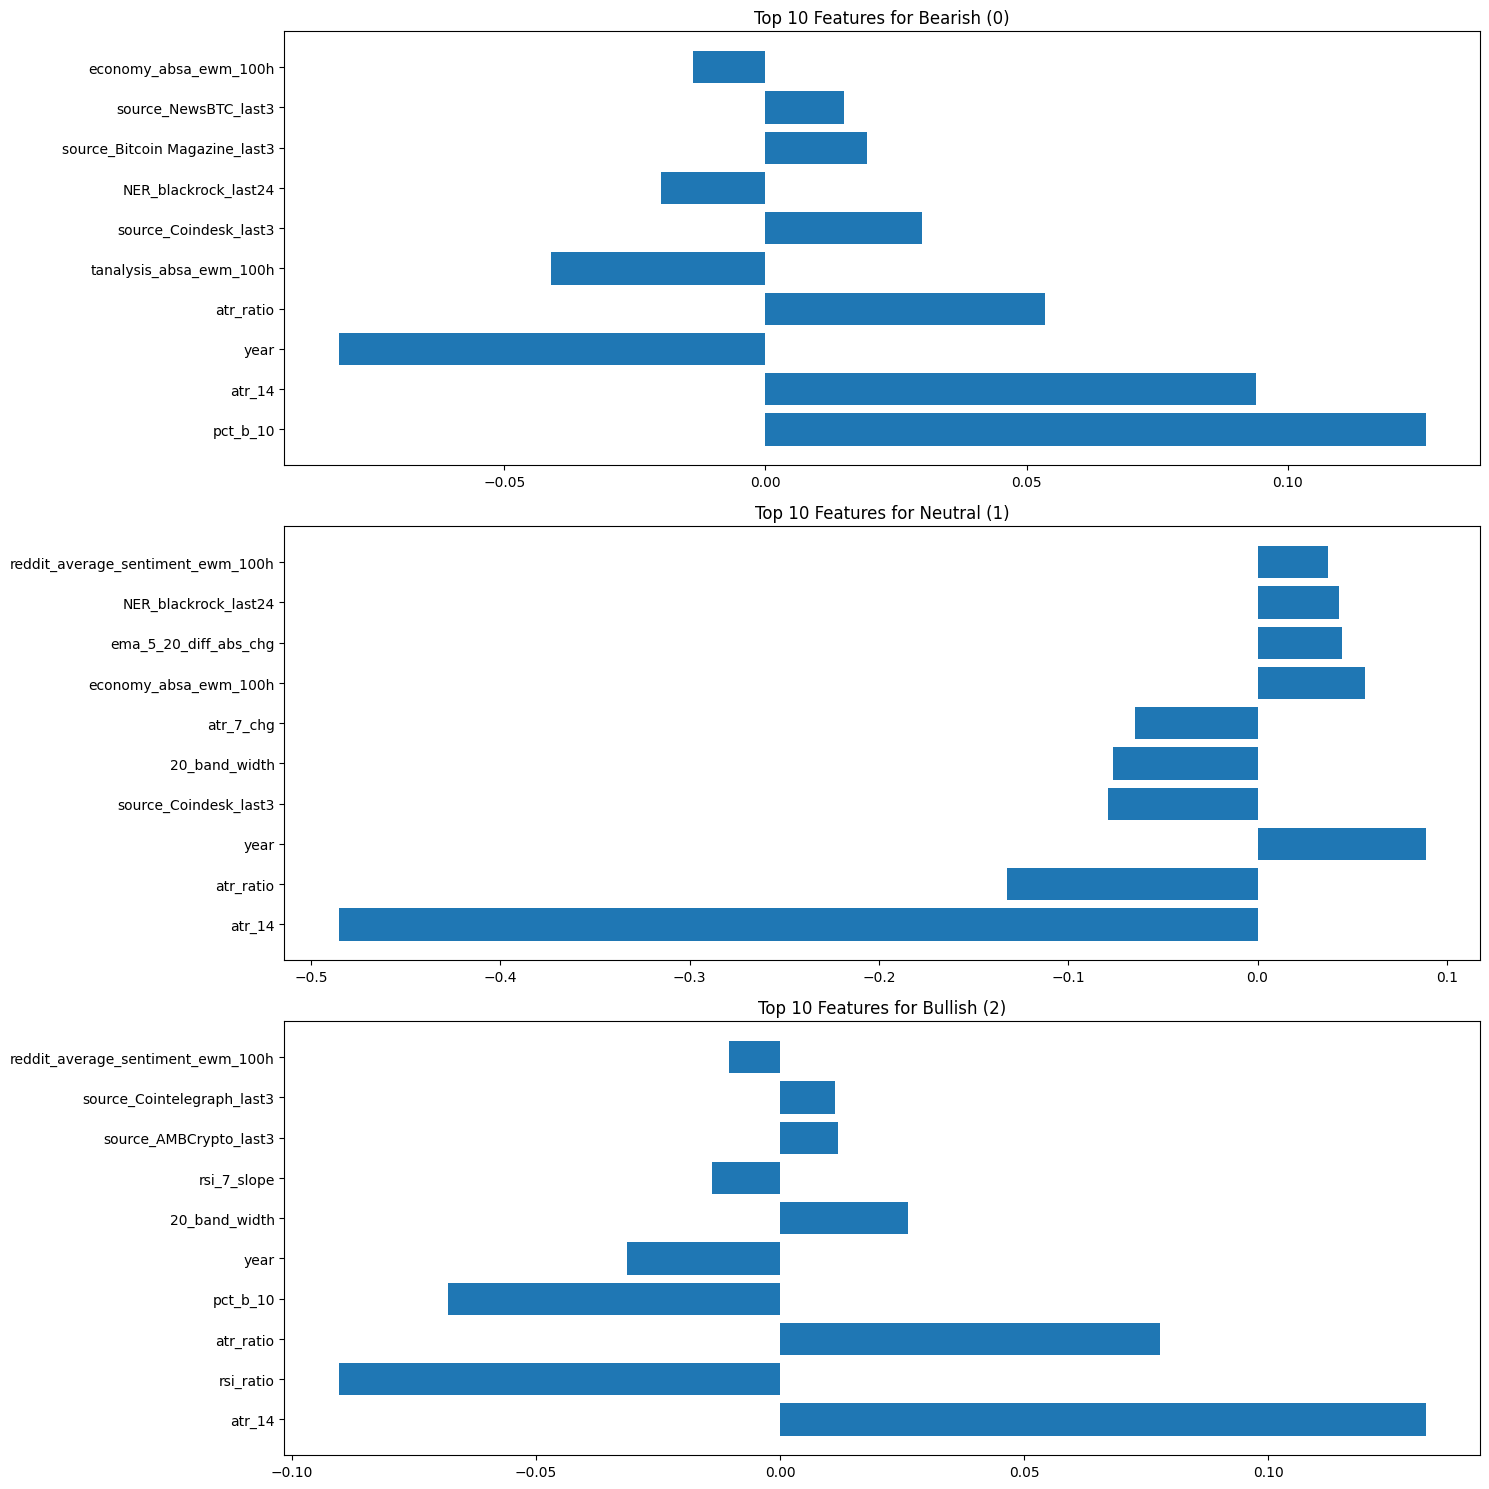


Number of features used by the model (non-zero coefficients): 63
Total number of features slots: 441
Feature utilization: 14.29%


In [ ]:
# Get the OneVsRestClassifier model from the pipeline
model = best_model.named_steps['model']

# Extract coefficients from each binary classifier within OneVsRestClassifier
# The estimators_ attribute holds the fitted estimator for each class.
# Each estimator's coef_ attribute has shape (1, n_features), so we stack them.
coefficients = np.vstack([est.coef_ for est in model.estimators_])

# Print the shape of coefficients to understand the structure
print(f"Shape of coefficient matrix: {coefficients.shape}")

# Get feature names
feature_names = X_train.columns

# Create a function to display coefficients for a class
def display_class_coefficients(class_idx, class_name):
  class_coefs = coefficients[class_idx]
  
  # Create a DataFrame
  coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': class_coefs
  })
  
  # Sort by absolute coefficient value
  coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
  coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
  
  # Display top features
  print(f"\nTop 15 most important features for {class_name}:")
  print(coef_df.head(15))
  
  return coef_df

# Display coefficients for each class
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)'] # Assuming classes are 0, 1, 2

plt.figure(figsize=(15, 15))

for i, class_name in enumerate(class_names):
  if i < coefficients.shape[0]: 
      coef_df = display_class_coefficients(i, class_name)
      
      plt.subplot(3, 1, i+1)
      if not coef_df.empty:
          top_features = coef_df.head(10)
          plt.barh(top_features['Feature'], top_features['Coefficient'])
          plt.title(f'Top 10 Features for {class_name}')
  else:
      print(f"Skipping plotting for class index {i}, as model might not have coefficients for it.")

plt.tight_layout()
plt.show()

# Count number of non-zero coefficients
# For multi_class, coefficients shape is (n_classes, n_features)
non_zero_coef = (np.abs(coefficients) > 1e-5).sum()
total_possible_coef = coefficients.shape[0] * coefficients.shape[1]
print(f"\nNumber of features used by the model (non-zero coefficients): {non_zero_coef}")
print(f"Total number of features slots: {total_possible_coef}")
if total_possible_coef > 0:
    print(f"Feature utilization: {non_zero_coef / total_possible_coef * 100:.2f}%")

In [9]:
# Make predictions on the test set - Using all features
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [10]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# For multiclass ROC AUC, specify multi_class='ovr' or 'ovo' and provide probabilities
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Test Set Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"\nROC AUC Score (One-vs-Rest): {roc_auc:.4f}")

Test Set Accuracy: 0.4836

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.17      0.25      2648
           1       0.52      0.79      0.62      3274
           2       0.45      0.42      0.43      2862

    accuracy                           0.48      8784
   macro avg       0.46      0.46      0.43      8784
weighted avg       0.47      0.48      0.45      8784


Confusion Matrix:
[[ 459 1186 1003]
 [ 189 2574  511]
 [ 417 1230 1215]]

ROC AUC Score (One-vs-Rest): 0.6961


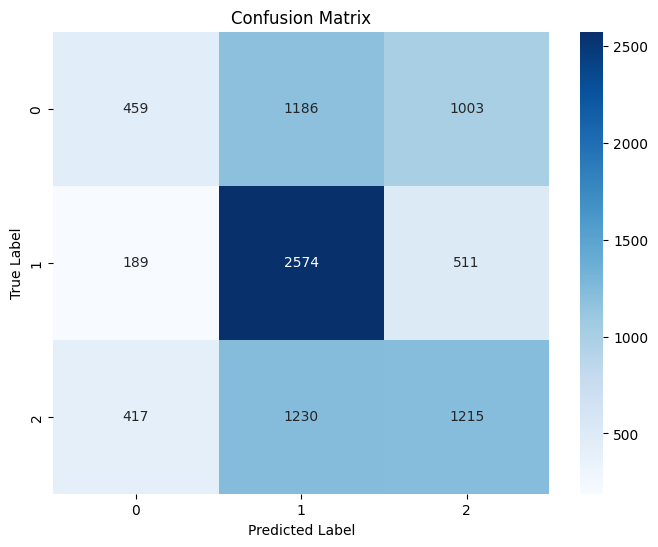

In [11]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

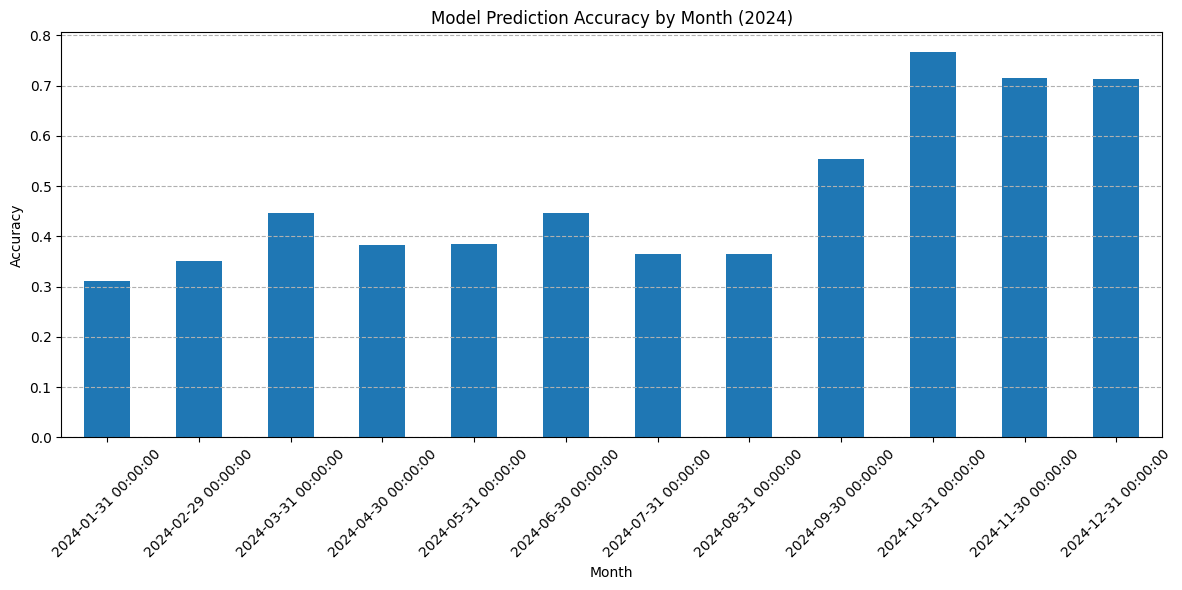

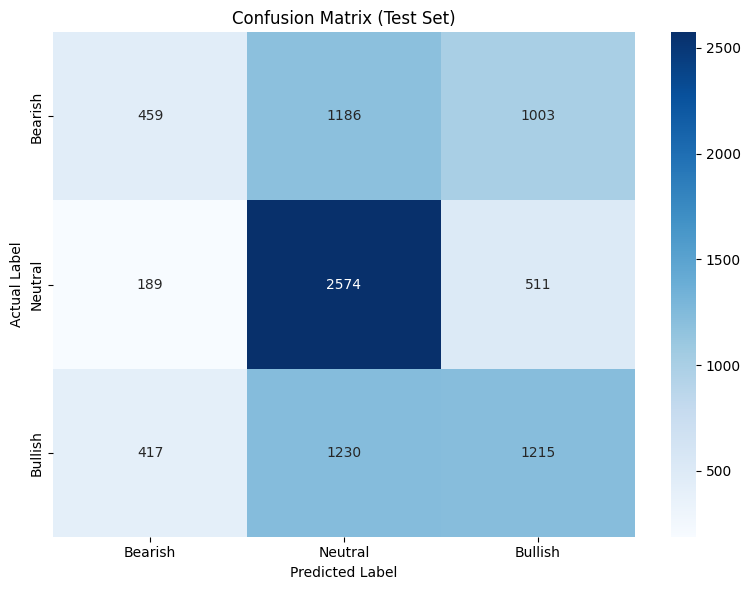

In [ ]:
# Add predictions and probabilities to test dataframe
df_test = df_test.copy()

df_test.loc[:, 'predicted_class'] = y_pred
df_test.loc[:, 'prob_bearish'] = y_pred_proba[:, 0]
df_test.loc[:, 'prob_neutral'] = y_pred_proba[:, 1]
df_test.loc[:, 'prob_bullish'] = y_pred_proba[:, 2]

# Define the mapping from numerical target to labels
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}

# Map target values to more descriptive labels
df_test.loc[:, 'actual_label'] = df_test['target'].map(target_map)
df_test.loc[:, 'predicted_label'] = df_test['predicted_class'].map(target_map)

# Calculate whether the prediction was correct
df_test.loc[:, 'correct_prediction'] = (df_test['target'] == df_test['predicted_class']).astype(int)

# Ensure the index is DatetimeIndex for resampling
if not isinstance(df_test.index, pd.DatetimeIndex):
  try:
    df_test.index = pd.to_datetime(df_test.index)
  except Exception as e:
    print(f"Could not convert index to DatetimeIndex: {e}")
    print("Monthly accuracy calculation requires a DatetimeIndex.")

# Calculate monthly accuracy
if isinstance(df_test.index, pd.DatetimeIndex):
  monthly_accuracy = df_test.resample('ME')['correct_prediction'].mean()

  # Plot monthly accuracy
  plt.figure(figsize=(12, 6))
  monthly_accuracy.plot(kind='bar')
  plt.title('Model Prediction Accuracy by Month (2024)')
  plt.ylabel('Accuracy')
  plt.xlabel('Month')
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--')
  plt.tight_layout()
  plt.show()
else:
  print("Skipping monthly accuracy plot as index is not DatetimeIndex.")


# Show confusion matrix with labels
conf_matrix_labeled = confusion_matrix(df_test['target'], df_test['predicted_class'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_labeled, annot=True, fmt='d', cmap='Blues',
      xticklabels=target_map.values(),
      yticklabels=target_map.values())
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [13]:
# Make prediction on the test set using the best model - Using all features
df_test['signal'] = best_model.predict(X_test)

# Display the first few rows with the new signal column
print(df_test[['target', 'signal']].head())

# Check the distribution of the predicted signals
print("\nPredicted signal distribution:")
print(df_test['signal'].value_counts())

                     target  signal
2024-01-01 00:00:00       0       1
2024-01-01 01:00:00       1       1
2024-01-01 02:00:00       0       1
2024-01-01 03:00:00       1       1
2024-01-01 04:00:00       2       1

Predicted signal distribution:
signal
1    4990
2    2729
0    1065
Name: count, dtype: int64


Overall Annual Return: 18.78%
Overall Annual Sharpe Ratio: 0.6155
Maximum Drawdown: -33.23 %
Alpha: -0.0183
Beta: 0.3041

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        0.18777    0.429903      0.30405     -0.018446       0.615464


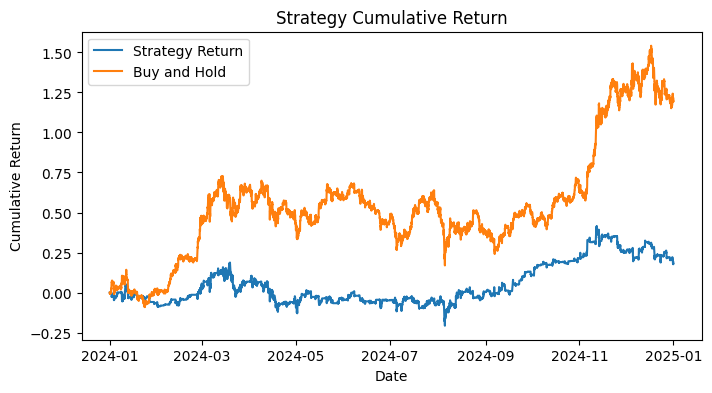

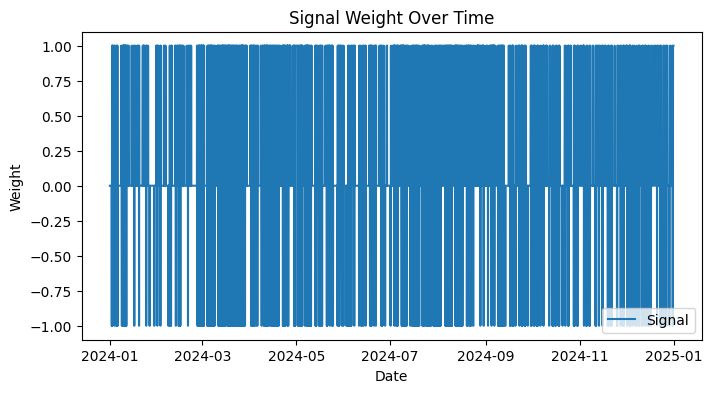

In [14]:
df_test['signal'] = df_test['signal'] - 1
run_backtest(df_test, 'h')